# LVM Data Simulator tutorial: installation, configuration and basic steps

**This is a tutorial on how to install, configure and test the very basic usage of the LVM Data Simulator.**
- More details on the setup of LVM instrumentation and on the structure of the outputs of the simulator are given in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)
- More realistic and useful simulations are considered in [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb) - please go there if you have already installed and configured the package and want to learn how to simulate the source field in more details.
- A dedicated function to run the simulator as an ETC is shown in [tutorial #4](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial4.ipynb) 

_Last update: 2022/11/02_

## Installation and setup

### Installing the package

The package can be found on github at this link: https://github.com/sdss/lvmdatasimulator

First clone the package with:

```git clone --recursive https://github.com/sdss/lvmdatasimulator --branch main```
    
then move into the package directory and install it with ``python -m pip install -e .``. Pip should automatically install all the dependencies needed for the simulator to work (if not, let us know!)

### Downloading libraries

Once the package is installed, you have to download three files that are temporarily stored in an FTP server at Universidad de Chile.

To download them you should run the following commands and move the files in the ```lvmdatasimulator/data``` directory:

```wget ftp@ftp.das.uchile.cl:/pub/enrico/LVM_cloudy_models.fits```

```wget ftp@ftp.das.uchile.cl:/pub/enrico/pollux_resampled_v0.fits```

At this point, everything should be ready to go. We just want to highlight that this is still a work-in-progress, and in the future how the simulator is called could change significantly. The goal is to write a main.py script able to read a configuration file.

**N.B.: This notebook should run just fine once you download and install the package. However, we suggest to move it to a different, empty directory, where it will be possible to save all the files produced during the test, or to change the work directory as follows:**

In [1]:
# Please do not run this cell, unless you want to change the work directory (not valid for running on UTAH cluster)
import os
os.chdir('/directory/where/I/want/to/save/all/files/')  # change to the correct path before running

## Part 1: Simulating the target field

The first step to perform the simulations is to create a field to be observed. Once the field is created, all its components can be saved to fits files and used again in future runs.

We first need to import all the necessary modules needed for the simulations:

In [2]:
import astropy.units as u
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

Then, we need to setup the LVM field object:

In [3]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, pxsize=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_pxsize=u.arcsec, name='LVM_test')

This line initializes the LVMField object. The needed inputs are:
- ra, dec: coordinates of the field to be observed. Used to build the WCS object
- size: size of the field to simulate
- pxsize: size of the spaxel
- unit_ra, unit_dec: unit used for the coordinates of the field, defaults to degrees
- unit size: unit of the size argument. defaults to arcmin
- unit_pxsize: unit of the spaxels, defaults to arcsec
- name: name of the field. It will be used to define the names of the output files. **Note:** all your intermediate and output files will be stored in the folder with this name under your working directory

The object is still empty, we need to generate the targets of the simulations. There are two types iof targets that can be simulated: **stars** and **nebulae**.

**Stars** are simulated by searching the GAIA catalog for stars brighter than a user defined limit. To each star we associate a spectrum, based on the estimated temperature of the object. All spectra are recovered from the pollux spectral library. **The library is missing spectra with temperature between 8000 and 12000 degrees. Stellar spectra should only be used for signal-to-noise ratio estimates, not to recover physical quantities**.

The stellar component is created as following:

In [7]:
my_lvmfield.generate_gaia_stars(gmag_limit=18)

[INFO]: 139 Gaia stars in the field
[INFO]: 101 stars are fainter than 18 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Rescaling 38 synthetic spectra.
[INFO]: Saving star list to: ./LVM_test/LVM_test_starlist.fits.gz


Once created, the star list is automatically saved to file, and it can be used to re-run the simulation without having to query GAIA again. The default position of this file is the current working directory, but it can be saved in another position by defining the *directory* argument. To read the saved file:

In [8]:
my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz')

[INFO]: Reading the star list from file ./LVM_test/LVM_test_starlist.fits.gz


The nebular component, on the other hand, contains a wide variety of different types of sources that can be created. While there are some core quantities shared among most types of sources, many need some type-specific keywords to be defined. For a complete view of the inputs needed for each kind of nebula, we refer to the code documentation and to the [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb), where the modelling of the ISM is presented in more details.

The nebular component should be passed to the field object as a list of dictionaries. Each dictionary represent a single nebula. Here we simulate only DIG component for simplicity:

In [9]:
my_nebulae = [{"type": 'DIG', 'max_brightness': 1e-17, 'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc},
              ]

To include the nebulae in the LVMField object we can use:

In [10]:
my_lvmfield.add_nebulae(my_nebulae, save_nebulae="testneb_tutorial1.fits")

[INFO]: Start generating 1 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'
[INFO]: Generated ISM saved to ./LVM_test/testneb_tutorial1.fits
[INFO]: ISM content saved to testneb_tutorial1.fits


The nebulae will be saved to file, so that they can be reused for other simulations without having to generate them. To read the nebulae from file:

In [11]:
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial1.fits")

[INFO]: Nebulae successfully loaded from file


 ## Part 2: Setting up the simulator


At this point the Field is ready to be observed. We are still missing, however, the complete instrument setup. The instrument is composed by a **telescope**, a **spectrograph** and a **fiber bundle**. To create the elements we just need to generate the objects as follows:

In [12]:
tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 5 hexagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


So far, we support a single telescope object LVM160() and a single spectrograph configuration LinearSpectrograph(). The latter, in particular, is a spectrograph with a 3650-9800 A wavelength range, and a constant 0.5 A dispersion.

The fiber bundle, on the other hand, is already pretty configurable. For now we will use a standard configuration. In [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb) we describe how to create and simulate different fiber configurations.

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 5 hexagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


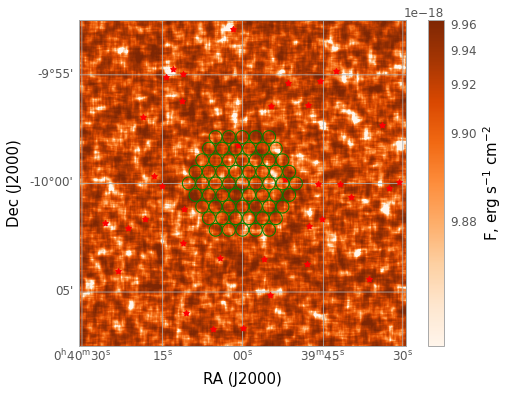

In [13]:
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='full_5.png')


The last step before running the simulator is to define the properties of the observations by initializing the **Observation** object. Also this object is configurable and all the different options will be described in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb).


In [14]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[24*900])


## Part 3: Running the simulator

Now we are ready to perform the simulation. First we initialize the simulator, giving it as an input all the things we already initialized:

In [15]:
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Them we can perform the simulations and save the outputs:

In [16]:
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570], unit_range=u.AA)

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 61 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./LVM_test/outputs/LVM_test_linear_full_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./LVM_test/outputs/LVM_test_linear_full_21600_no_noise.fits saved.
[INFO]: Uncalibrated outputs
[INFO]: ./LVM_test/outputs/LVM_test_linear_full_21600_realization.fits saved.
[INFO]: Calibrated outputs
[INFO]: ./LVM_test/outputs/LVM_test_linear_full_21600_flux.fits saved.
[INFO]: Saving the 2D output maps
[INFO]:  Sa

Also a detailed description of the outputs will be provided in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb).

## Part 4: running the simulator - easy version

If the user do not want to manually setup the simulations, we prepared a small script that accepts as an input a dictionary which contains all the parameters needed to produce the simulations. If a parameter is not present in the dictionary, a default value will be used. To take advantage of this new approach, first we need to import the script and the astropy units package (in case if you want to explicitly define the quantities):

In [17]:
from lvmdatasimulator.run import run_simulator_1d

import astropy.units as u

Then, we have to prepare a list with all the nebulae that should be simulated.

In [18]:
my_nebulae = [{"type": 'DIG', 'max_brightness': 1e-17,
               'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc}
              ]

In this case we are simulating the same field described in Part 1 of this tutorial. If a source field is already available, it is possible to use it by providing its name in the dictionary using the ```nebulae_from_file``` keyword.

Then, we need to setup the dictionary as follows:

In [21]:
parameters = dict(
                  # LVMField inputs
                  ra=10,  # RA of the source field
                  dec=-10,  # DEC of the source field
                  size=15,  # size of the source field
                  pxsize=1,  # spaxel size of the source field
                  unit_ra=u.degree,  # unit of RA
                  unit_dec=u.degree,  # unit of DEC
                  unit_size=u.arcmin,  # unit of size
                  unit_pxsize=u.arcsec,  # unit of spaxel
                  name='LVM_test',  # name of the field

                  # Nebulae generation
                  nebulae=my_nebulae,  # list of dictionaries defining the nebulae in the field
                  nebulae_name="testneb_tutorial1.fits",  # name of the output source field file

                  # Star list generation
                  gmag_limit=18,  # maximum magnitude of gaia stars to include in the field

                  # save input/output map
                  wavelength_ranges=[[6550, 6570]],  # wavelength ranges to integrate for the input and output maps
                  unit_range=u.AA,  # units of measurement of the wavelength ranges

                  # parameters of Observation
                  ra_bundle=10,  # RA of the center of the bundle
                  dec_bundle=-10,  # DEC of the center of the bundle
                  unit_ra_bundle=u.deg,  # unit of ra_bundle
                  unit_dec_bundle=u.deg,  # unit of dec_bundle
                  exptimes=[24*900],  # list of exposure times in s

                  # bundle properties
                  bundle_name='full',  # type of fiber configuration
                  nrings=10,  # number of rings to simulate
                  angle=0,  # rotation to apply to the bundle.

                  # parameters of the simulator
                  fast=True  # use normal interpolation or precise resampling.
)

This dictionary will setup exactly the same configuration we simulate before during this tutorial, with the exception of the bundle, which will be in a 10 rings "full" configuration.

It is possible now to run the simulator as follows:

In [22]:
run_simulator_1d(parameters)

[INFO]: Start generating 1 nebulae
[INFO]: Generated ISM saved to ./LVM_test/testneb_tutorial1.fits
[INFO]: ISM content saved to testneb_tutorial1.fits
[INFO]: 139 Gaia stars in the field
[INFO]: 101 stars are fainter than 18 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Rescaling 38 synthetic spectra.
[INFO]: Saving star list to: ./LVM_test/LVM_test_starlist.fits.gz


[WARNING]: The file ././LVM_test/LVM_test_starlist.fits.gz already exist and it will be overwritten
[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_test_6550_6570_input_map.fits
[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 10 hexagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 271 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
[INFO]: Resampling spectra to the instrument wavelength soluti

Elapsed time: 93.2


Multiple images can be produced at the same time, by providing a list of wavelength ranges to be integrated.

Multiple images can be produced at the same time, by providing a list of wavelength ranges to be integrated.